# 프로젝트 : CIFAR-10 이미지 생성하기

## STEP 1. 작업환경 구성하기

In [35]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.18.0


## STEP 2. 데이터셋 구성하기

In [36]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [37]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


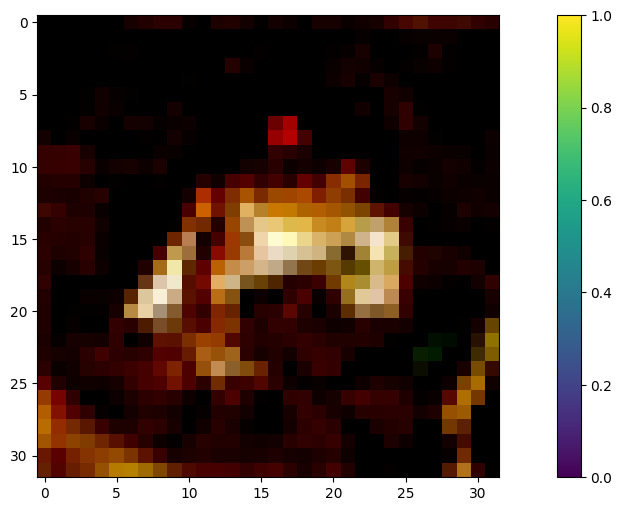

In [40]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

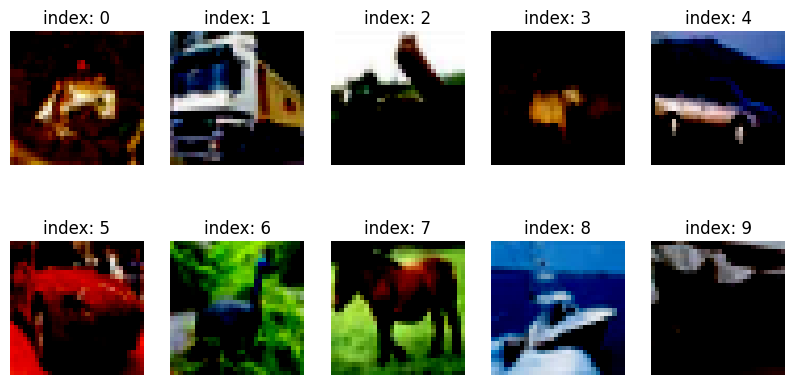

In [41]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [42]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기

In [44]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # (배치사이즈, 8, 8, 256)

    # 8x8 → 16x16
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 16x16 → 32x32
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 최종 출력: 32x32x3 (RGB 이미지)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [45]:
generator = make_generator_model()

generator.summary()

/mnt/e/.pyenv/versions/3.9.7/envs/aiffel_env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [46]:
noise = tf.random.normal([1, 100])

In [47]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

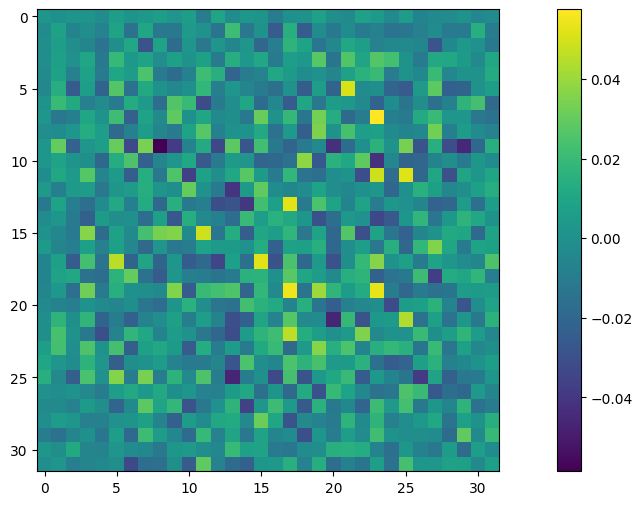

In [48]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기

In [49]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 입력: 32x32x3 이미지
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 16x16x64 → 8x8x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 8x8x128 → 4x4x256 (추가 레이어)
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten Layer
    model.add(layers.Flatten())

    # Dense Layer (출력: 1)
    model.add(layers.Dense(1))

    return model

In [50]:
discriminator = make_discriminator_model()

discriminator.summary()

/mnt/e/.pyenv/versions/3.9.7/envs/aiffel_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,345 (3.94 MB)

 Trainable params: 1,033,345 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00178879]], dtype=float32)>

In [52]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## STEP 5. 손실함수와 최적화 함수 구현하기

In [53]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [54]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # [[YOUR CODE]]
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # [[YOUR CODE]]
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss # [[YOUR CODE]]
    return total_loss

In [55]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [56]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [57]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [59]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    # plt.savefig('{}/aiffel/HelloWorld/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
    #                 .format(os.getenv('HOME'), epoch, it))
    base_path = '/mnt/e/aiffel/HelloWorld/dcgan_newimage/cifar10/generated_samples'
    plt.savefig('{}/sample_epoch_{:04d}_iter_{:03d}.png'.format(base_path, epoch, it))


    plt.show()

In [60]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    base_path = '/mnt/e/aiffel/HelloWorld/dcgan_newimage/cifar10/training_history'
    plt.savefig('{}/train_history_{:04d}.png'.format(base_path, epoch))

    plt.show()

In [61]:
checkpoint_dir = '/mnt/e/aiffel/HelloWorld/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

In [62]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [63]:
save_every = 5
EPOCHS = 20

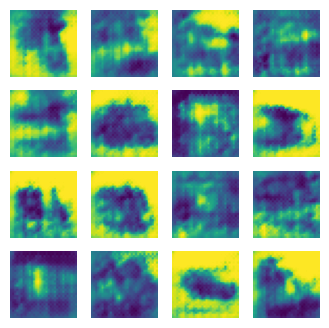

Time for training : 6287 sec


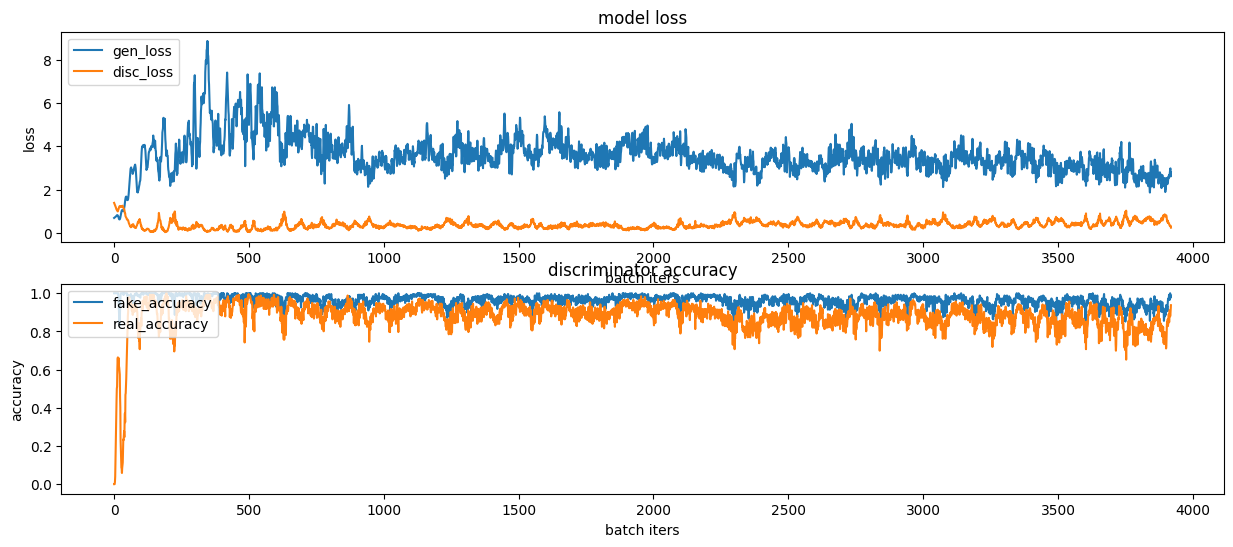

CPU times: user 12h 4min 25s, sys: 16min 40s, total: 12h 21min 5s
Wall time: 1h 44min 50s


In [64]:
%%time
train(train_dataset, EPOCHS, save_every)

In [65]:
anim_file = '/mnt/e/aiffel/HelloWorld/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    # filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = glob.glob('/mnt/e/aiffel/HelloWorld/dcgan_newimage/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /mnt/e/aiffel/HelloWorld/dcgan_newimage/cifar10/cifar10_dcgan.gif

/tmp/ipykernel_21086/1456025736.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_21086/1456025736.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


-rwxrwxrwx 1 ksa ksa 634140 Feb 10 15:20 /mnt/e/aiffel/HelloWorld/dcgan_newimage/cifar10/cifar10_dcgan.gif


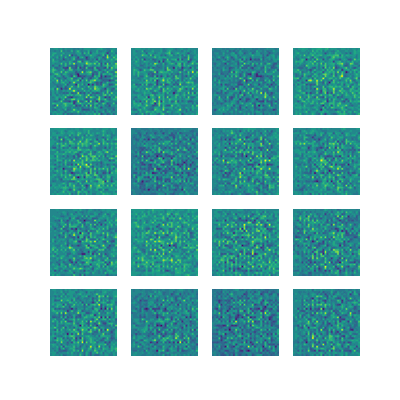

In [69]:
gif_path = "/mnt/e/aiffel/HelloWorld/dcgan_newimage/cifar10/cifar10_dcgan.gif"

# GIF 출력
with PIL.Image.open(gif_path) as gif:
    display.display(gif)

## STEP 8. (optional) GAN 훈련 과정 개선하기

### 주요 문제점 분석

1. 모드 붕괴

    - 특정 종류의 이미지 패턴만 생성하는 현상으로, 다양성이 부족한 생성 결과가 나타남.
    - 이유: Generator가 Discriminator의 특정 패턴을 속이는 전략을 학습하면서 전체 데이터 분포를 학습하지 않음.


2. 훈련 불안정성

    - GAN의 학습은 Generator와 Discriminator 간의 균형이 중요하지만, 한쪽이 너무 강해질 경우 학습이 불안정해질 수 있음.
    - Discriminator가 너무 강하면 Generator의 학습이 어려워지고, 반대로 Generator가 너무 강하면 Discriminator가 무력화됨.


3. Gradient Vanishing 문제

    - 특히 초기 학습 단계에서 Discriminator가 너무 잘 학습되면 Gradient가 거의 전달되지 않아 Generator의 학습이 어려워지는 문제가 발생함.


4. 배치 정규화의 과도한 사용

    - Batch Normalization은 학습을 안정화하지만, DCGAN에서는 BN을 모든 층에서 사용하면 훈련이 오히려 불안정해질 수 있음.
    - 특히 Discriminator에서 BN을 많이 사용하면 작은 배치 크기에서 불안정한 학습을 초래할 가능성이 높음.


5. 생성된 이미지의 세밀한 디테일 부족

    - DCGAN은 고해상도 이미지 생성이 어려우며, 디테일이 부족한 결과물이 나올 수 있음.

### 모델 구조 및 학습 과정 개선 방안

1. Wasserstein GAN(WGAN) 적용
    - Wasserstein Loss를 사용하면 학습 안정성이 향상되며, Mode Collapse가 완화됨.
    - 기존의 Binary Crossentropy 대신 Wasserstein Loss를 활용.
    - 변경 제안
        ```
        def generator_loss(fake_output):
            return -tf.reduce_mean(fake_output)

        def discriminator_loss(real_output, fake_output):
            return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
        ```

2. Spectral Normalization 적용
    - Discriminator에서 Batch Normalization 대신 Spectral Normalization을 적용하면 Gradient Vanishing 및 학습 불안정 문제를 완화할 수 있음.
    - 이는 Discriminator의 Lipschitz Continuity를 유지하여 학습 안정성을 높이는 역할을 함.
    - 변경 제안
        ```
        from tensorflow_addons.layers import SpectralNormalization

        def make_discriminator_model():
            model = tf.keras.Sequential()

            model.add(SpectralNormalization(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3])))
            model.add(layers.LeakyReLU())
            model.add(layers.Dropout(0.3))

            model.add(SpectralNormalization(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')))
            model.add(layers.LeakyReLU())
            model.add(layers.Dropout(0.3))

            model.add(SpectralNormalization(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')))
            model.add(layers.LeakyReLU())
            model.add(layers.Dropout(0.3))

            model.add(layers.Flatten())
            model.add(layers.Dense(1))

            return model
        ```


3. Generator에 Self-Attention 추가
    - DCGAN은 Conv2DTranspose만을 사용하여 이미지를 생성하는데, Self-Attention을 추가하면 더 세밀한 패턴을 학습할 수 있음.
    - 변경 제안
        ```
        import tensorflow.keras.layers as layers
        from tensorflow.keras.layers import MultiHeadAttention

        def make_generator_model():
            model = tf.keras.Sequential()
            model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
            model.add(layers.BatchNormalization())
            model.add(layers.LeakyReLU())

            model.add(layers.Reshape((8, 8, 256)))
            
            # 8x8 → 16x16
            model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
            model.add(layers.BatchNormalization())
            model.add(layers.LeakyReLU())

            # Self-Attention Layer 추가
            model.add(MultiHeadAttention(num_heads=4, key_dim=128))

            # 16x16 → 32x32
            model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
            model.add(layers.BatchNormalization())
            model.add(layers.LeakyReLU())

            model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

            return model
        ```


4. One-Sided Label Smoothing 적용

    - Real Label(1)을 0.9로 살짝 낮추어 Discriminator가 너무 쉽게 1을 예측하지 않도록 함.
    - 이를 통해 Discriminator가 Robust하게 학습될 수 있음.
    - 변경 제안
        ```
        def discriminator_loss(real_output, fake_output):
            real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
            total_loss = real_loss + fake_loss
            return total_loss
        ```
5. Adam 대신 RMSprop 또는 Adaptive Learning 적용

    - Adam Optimizer의 Momentum이 GAN 학습에 불안정성을 초래할 수 있으므로, RMSprop을 사용하거나 Adaptive Learning Rate 적용.
    - 변경 제안
        ```
        generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
        discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
        ```
